## Importations

In [1]:
import mne 
import os
import pickle
import argparse
import scipy.stats
import matplotlib
import sklearn

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.utils import get_bids_file, compute_ch_adjacency
from src.params import PREPROC_PATH, FREQS_LIST, FREQS_NAMES, EVENTS_ID, RESULT_PATH, SUBJ_CLEAN, FIG_PATH, ACTIVE_RUN, PASSIVE_RUN
from mne.time_frequency import (tfr_morlet, AverageTFR)
from mne.stats import spatio_temporal_cluster_test, spatio_temporal_cluster_1samp_test
from mne.stats import permutation_cluster_1samp_test,  permutation_cluster_test
from mne.stats import (
    spatio_temporal_cluster_test,
    f_threshold_mway_rm,
    f_mway_rm,
    summarize_clusters_stc,
)
from mne.stats import permutation_cluster_test

In [3]:
# Conditions and task to compute
task = 'LaughterPassive'
stage = 'psd_epo'
cond1 = 'LaughReal'
cond2 = 'LaughPosed'
freq_name = FREQS_NAMES
condition = [cond1, cond2] # assert 2 conditions
save = False        

if task == 'LaughterActive':
    run_list = ACTIVE_RUN
elif task == 'LaughterPassive':
    run_list = PASSIVE_RUN

subj_list = SUBJ_CLEAN

## T-test clustering : Hilbert tranform
# ----------------------------------------INDUCED---------------------------------------------------

### 1. Prepare data

In [3]:
freq_name = FREQS_NAMES
condition = [cond1, cond2] # assert 2 conditions
list_good_cluster_inds = []

for FREQ, fname in enumerate(freq_name) : 

    for i, cond in enumerate(condition) :
        print('condition -->', cond)
        list_epochs_ave = []
        list_all_data = []
        
        for subj in SUBJ_CLEAN :
            print("processing subject -->", subj)
            list_epochs = []
            epochs_time = []

            for run in PASSIVE_RUN :
                print("processing run -->", run)
                
                # Get hilbert filtered data
                _, psd_path = get_bids_file(RESULT_PATH, 
                                            stage=stage, 
                                            subj=subj, 
                                            task=task, 
                                            run=run, 
                                            measure=fname)
                epochs = mne.read_epochs(psd_path, verbose=None)
                
                # Appliquer la correction baseline
                epochs = epochs.apply_baseline(baseline=(None, 0))
                list_epochs.append(epochs[cond])
                
            # Need to equalize event count
            mne.epochs.equalize_epoch_counts(list_epochs)

            for epo in list_epochs : # Use epochs with equal n_events

                # Moyenner chaque epoch dans le temps pour chaque condition
                epochs_ave_time = np.mean(epo.get_data(), axis = 2) # Shape (n_events, n_channels)
                epochs_time.append(epochs_ave_time) # len = n_runs

            epochs_ave_runs = np.mean(np.array(epochs_time), axis = 0) # Average across runs
            epochs_ave_event = np.mean(epochs_ave_runs, axis = 0) # Average across epochs
            list_epochs_ave.append(epochs_ave_event) # Shape (n_chan)

        # Concat subjects
        data_subj = np.array(list_epochs_ave)  # Shape (n_subj, n_chan)
        list_all_data.append(data_subj) # Append per freqs

        # Concat freqs fon each cond
        if i == 0 : 
            all_data_cond1 = np.array(list_all_data)
            all_data_cond1 = np.transpose(all_data_cond1, [1, 0, 2])
            #all_data_cond1 = data_subj
        elif i == 1 : 
            all_data_cond2 = np.array(list_all_data)
            all_data_cond2 = np.transpose(all_data_cond2, [1, 0, 2])
            #all_data_cond2 = data_subj
        
    print('all data condition 1 :', all_data_cond1.shape)  # Shape (n_subj, n_freq, n_chan)
    print('all data condition 2 :', all_data_cond2.shape)  # Shape (n_subj, n_freq, n_chan)

    data_contrast = np.subtract(all_data_cond1, all_data_cond2)

    print(data_contrast.shape)
    data_contrast = np.subtract(all_data_cond1, all_data_cond2)

    # Application de cluster permutation
    print('Computing adjacency.')
    adjacency, ch_names = compute_ch_adjacency(epochs.info, ch_type='mag')
    print(adjacency.shape)

    pval = 0.01  # arbitrary
    dfn = len([all_data_cond1, all_data_cond2]) - 1  # degrees of freedom numerator
    dfd = len(all_data_cond1) - len([all_data_cond1, all_data_cond2])  # degrees of freedom denominator
    thresh = scipy.stats.f.ppf(1 - pval, dfn=dfn, dfd=dfd)  # F distribution

    cluster_stats = \
        permutation_cluster_1samp_test(data_contrast, 
                                 adjacency = adjacency, 
                                 out_type='indices',
                                 n_permutations=1024, 
                                 threshold=None, 
                                 tail=0,
                                 step_down_p=0.05)

    list_good_cluster_inds.append(cluster_stats)

condition --> LaughReal
processing subject --> 01
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-02_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-03_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_tas

Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-04_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-05_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 5 epochs: 4, 5, 9, 10, 11
Dropped 0 epochs: 
Dropped 5 epochs: 2, 3, 5, 6, 11
Dropped 0 epochs: 
processing subject --> 06
processing run --> 02
Reading /home/claraelk/

Dropped 0 epochs: 
processing subject --> 10
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-02_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-03_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-Lau

    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-05_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 5 epochs: 2, 3, 4, 11, 14
Dropped 0 epochs: 
Dropped 5 epochs: 0, 2, 4, 5, 6
Dropped 0 epochs: 
processing subject --> 15
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-15/sub-15_task-LaughterPassive_run-02_meas-delta_psd_epo.fif ...
    Found the data of in

    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-03_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-04_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching ev

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-05_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 6 epochs: 1, 4, 6, 7, 13, 14
Dropped 1 epoch: 9
Dropped 6 epochs: 1, 4, 6, 7, 13, 14
Dropped 0 epochs: 
processing subject --> 25
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-25/sub-25_task-LaughterPassive_run-02_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting meta

        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-03_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-04_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correctio

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-05_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 2, 6, 7, 9, 11
Dropped 0 epochs: 
Dropped 5 epochs: 5, 7, 9, 10, 14
processing subject --> 06
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-06/sub-06_task-LaughterPassive_run-02_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50

        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-03_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-04_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Ap

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-05_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 0, 1, 2, 3, 13
Dropped 0 epochs: 
Dropped 5 epochs: 0, 1, 2, 3, 5
processing subject --> 15
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-15/sub-15_task-LaughterPassive_run-02_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 m

        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-03_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-04_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Ap

50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-05_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 3, 6, 11
Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 3, 4, 5
processing subject --> 25
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-25/sub-25_task-LaughterPassive_run-02_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found


Found 2 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
condition --> LaughReal
processing subject --> 01
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-02_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-03_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --

0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-04_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-05_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 5 epochs: 4, 5, 9, 10, 11
Dropped 0 epochs: 
Dropped 5 epochs: 2, 3, 5, 6, 

Dropped 5 epochs: 2, 7, 8, 9, 12
Dropped 0 epochs: 
Dropped 5 epochs: 2, 7, 8, 9, 14
Dropped 0 epochs: 
processing subject --> 10
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-02_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-03_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Re

Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-04_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-05_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 5 epochs: 2, 3, 4, 11, 14
Dropped 0 epochs: 
Dropped 5 epochs: 0, 2, 4, 5, 6
Dropped 0 epochs: 
processi

Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 3, 5, 8
Dropped 0 epochs: 
processing subject --> 20
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-02_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-03_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laugh

Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-04_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-05_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 5 epochs: 2, 3, 4, 7, 14
Dropped 0 epochs: 
Dropped 5 epochs: 0, 3, 4, 7, 8
Dropped 0 epochs: 
processin

Dropped 0 epochs: 
Dropped 5 epochs: 0, 4, 5, 10, 13
Dropped 0 epochs: 
condition --> LaughPosed
processing subject --> 01
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-02_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-03_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /

0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-04_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-05_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 2, 6, 7, 9, 11
Dropped 0 epochs: 
Dropped 5 ep

Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 7, 8, 9
Dropped 0 epochs: 
Dropped 5 epochs: 0, 6, 7, 8, 10
processing subject --> 10
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-02_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-03_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Rea

0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-04_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-05_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 0, 1, 2, 3, 13
Dropped 0 epochs: 
Dropped 5 ep

Dropped 0 epochs: 
Dropped 5 epochs: 0, 3, 6, 7, 10
Dropped 0 epochs: 
Dropped 5 epochs: 0, 1, 4, 5, 8
processing subject --> 20
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-02_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-03_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Rea

0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-04_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-05_meas-theta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 3, 6, 11
Dropped 0 epochs: 
Dropped 5 ep

Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 3, 10, 11
Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 3, 7, 10
all data condition 1 : (27, 1, 270)
all data condition 2 : (27, 1, 270)
(27, 1, 270)
Computing adjacency.
-- number of adjacent vertices : 270
(270, 270)
Using a threshold of 2.055529
stat_fun(H1): min=-2.171714 max=3.304505
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
condition --> LaughReal
processing subject --> 01
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-02_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-03_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --

0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-04_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-05_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 5 epochs: 4, 5, 9, 10, 11
Dropped 0 epochs: 
Dropped 5 epochs: 2, 3, 5, 6, 

Dropped 5 epochs: 2, 7, 8, 9, 12
Dropped 0 epochs: 
Dropped 5 epochs: 2, 7, 8, 9, 14
Dropped 0 epochs: 
processing subject --> 10
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-02_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-03_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Re

Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-04_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-05_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 5 epochs: 2, 3, 4, 11, 14
Dropped 0 epochs: 
Dropped 5 epochs: 0, 2, 4, 5, 6
Dropped 0 epochs: 
processi

Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 3, 5, 8
Dropped 0 epochs: 
processing subject --> 20
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-02_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-03_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laugh

processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-04_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-05_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 5 epochs: 2, 3, 4, 7, 14
Dropped 0 epochs: 
Dropped 5 epochs: 0, 3, 4, 7, 8
Dropped 0 epochs: 
processing subject --> 25
processing run --> 02
Rea

Dropped 0 epochs: 
condition --> LaughPosed
processing subject --> 01
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-02_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-03_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/repor

processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-04_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-05_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 2, 6, 7, 9, 11
Dropped 0 epochs: 
Dropped 5 epochs: 5, 7, 9, 10, 14
processing subject --> 06
processing run --> 02
R

Dropped 5 epochs: 0, 6, 7, 8, 10
processing subject --> 10
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-02_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-03_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/s

processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-04_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-05_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 0, 1, 2, 3, 13
Dropped 0 epochs: 
Dropped 5 epochs: 0, 1, 2, 3, 5
processing subject --> 15
processing run --> 02
Rea

Dropped 0 epochs: 
Dropped 5 epochs: 0, 1, 4, 5, 8
processing subject --> 20
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-02_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-03_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/me

processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-04_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-05_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 3, 6, 11
Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 3, 4, 5
processing subject --> 25
processing run --> 02
Rea

Dropped 5 epochs: 1, 2, 3, 7, 10
all data condition 1 : (27, 1, 270)
all data condition 2 : (27, 1, 270)
(27, 1, 270)
Computing adjacency.
-- number of adjacent vertices : 270
(270, 270)
Using a threshold of 2.055529
stat_fun(H1): min=-0.969247 max=3.170516
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
condition --> LaughReal
processing subject --> 01
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-02_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-03_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 

Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-04_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-05_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 5 epochs: 4, 5, 9, 10, 11
Dropped 0 epochs: 
Dropped 5 epochs: 2, 3, 5, 6, 11
Dropped 0 epochs: 
processin

Dropped 5 epochs: 2, 7, 8, 9, 14
Dropped 0 epochs: 
processing subject --> 10
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-02_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-03_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg

    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-05_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 5 epochs: 2, 3, 4, 11, 14
Dropped 0 epochs: 
Dropped 5 epochs: 0, 2, 4, 5, 6
Dropped 0 epochs: 
processing subject --> 15
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-15/sub-15_task-LaughterPassive_run-02_meas-beta_psd_epo.fif ...
    Found the data of inte

    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-03_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-04_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching even

        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-05_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 5 epochs: 2, 3, 4, 7, 14
Dropped 0 epochs: 
Dropped 5 epochs: 0, 3, 4, 7, 8
Dropped 0 epochs: 
processing subject --> 25
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-25/sub-25_task-LaughterPassive_run-02_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation 

    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-03_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-04_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching even

        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-05_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 2, 6, 7, 9, 11
Dropped 0 epochs: 
Dropped 5 epochs: 5, 7, 9, 10, 14
processing subject --> 06
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-06/sub-06_task-LaughterPassive_run-02_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensatio

        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-03_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-04_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction 

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-05_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 0, 1, 2, 3, 13
Dropped 0 epochs: 
Dropped 5 epochs: 0, 1, 2, 3, 5
processing subject --> 15
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-15/sub-15_task-LaughterPassive_run-02_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 mat

        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-03_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-04_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Appl

No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-05_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 3, 6, 11
Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 3, 4, 5
processing subject --> 25
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-25/sub-25_task-LaughterPassive_run-02_meas-beta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction appl

  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
condition --> LaughReal
processing subject --> 01
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-02_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-03_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --

0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-04_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-05_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 5 epochs: 4, 5, 9, 10, 11
Dropped 0 epochs: 
Dropped 5 epochs: 2, 3, 5, 6, 

Dropped 5 epochs: 2, 7, 8, 9, 12
Dropped 0 epochs: 
Dropped 5 epochs: 2, 7, 8, 9, 14
Dropped 0 epochs: 
processing subject --> 10
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-02_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-03_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Re

Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-04_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-05_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 5 epochs: 2, 3, 4, 11, 14
Dropped 0 epochs: 
Dropped 5 epochs: 0, 2, 4, 5, 6
Dropped 0 epochs: 
processi

Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 3, 5, 8
Dropped 0 epochs: 
processing subject --> 20
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-02_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-03_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laugh

processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-04_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-05_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 5 epochs: 2, 3, 4, 7, 14
Dropped 0 epochs: 
Dropped 5 epochs: 0, 3, 4, 7, 8
Dropped 0 epochs: 
processing subject --> 25
processing run --> 02
Rea

Dropped 0 epochs: 
condition --> LaughPosed
processing subject --> 01
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-02_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-03_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/repor

processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-04_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-05_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 2, 6, 7, 9, 11
Dropped 0 epochs: 
Dropped 5 epochs: 5, 7, 9, 10, 14
processing subject --> 06
processing run --> 02
R

Dropped 5 epochs: 0, 6, 7, 8, 10
processing subject --> 10
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-02_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-03_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/s

processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-04_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-05_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 0, 1, 2, 3, 13
Dropped 0 epochs: 
Dropped 5 epochs: 0, 1, 2, 3, 5
processing subject --> 15
processing run --> 02
Rea

Dropped 0 epochs: 
Dropped 5 epochs: 0, 1, 4, 5, 8
processing subject --> 20
processing run --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-02_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-03_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/me

processing run --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-04_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing run --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-05_meas-gamma_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 3, 6, 11
Dropped 0 epochs: 
Dropped 5 epochs: 1, 2, 3, 4, 5
processing subject --> 25
processing run --> 02
Rea

Dropped 5 epochs: 1, 2, 3, 7, 10
all data condition 1 : (27, 1, 270)
all data condition 2 : (27, 1, 270)
(27, 1, 270)
Computing adjacency.
-- number of adjacent vertices : 270
(270, 270)
Using a threshold of 2.055529
stat_fun(H1): min=-2.472452 max=1.821477
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations


In [3]:
# Save cluster stats to use it later
# TODO : save all subject evoked_cond1 et cond2 
conditions = cond1 + "-" + cond2

_, save_contrasts = get_bids_file(RESULT_PATH, stage = "psd-contrast", task=task, condition = conditions)

_, save_cluster_stats = get_bids_file(RESULT_PATH, stage = "psd-clusters", task=task, measure="Ttest-clusters", condition = conditions)

with open(save_contrasts, 'wb') as f:
     pickle.dump(data_contrast, f)  

with open(save_cluster_stats, 'wb') as f:
    pickle.dump(cluster_stats, f)  

NameError: name 'data_contrast' is not defined

### Test-t without permutation

In [11]:
# Save cluster stats to use it later
# TODO : save all subject evoked_cond1 et cond2 
conditions = cond1 + "-" + cond2

_, save_contrasts = get_bids_file(RESULT_PATH, stage = "psd-contrast", task=task, condition = conditions)

_, save_cluster_stats = get_bids_file(RESULT_PATH, stage = "psd-clusters", task=task, measure="Ttest-clusters", condition = conditions)

with open(save_contrasts, 'rb') as f:
     data_contrast = pickle.load(f)  

with open(save_cluster_stats, 'rb') as f:
    cluster_stats = pickle.load(f)  

In [8]:
# Test-t sans permutations, ni corrections pour la valeur de p

tval, pval = scipy.stats.ttest_rel(all_data_cond1, all_data_cond2)

good_pvalues_inds = np.where(pval < 0.01)[1]
print(good_pvalues_inds)

tvalues = np.squeeze(tval)
print(tvalues.shape)

NameError: name 'all_data_cond1' is not defined

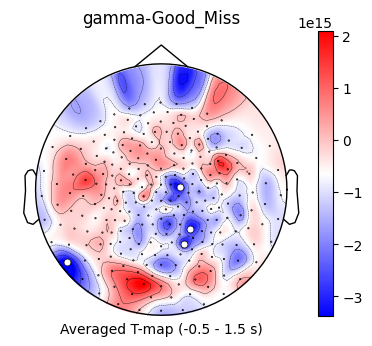

In [27]:
chan = np.arange(0, 270, 1)
mask = []

# initialize figure
fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

for i, ch in enumerate(chan) :
    if i in good_pvalues_inds : 
        mask.append((True, 0))
    else :
        mask.append((False, 0))
        
mask = np.array(mask)

# plot average test statistic and mark significant sensors
evoked = mne.EvokedArray(tvalues[:, np.newaxis], epochs.info, tmin=0)
evoked.plot_topomap(times=0, axes=ax_topo, cmap='bwr',
                    vlim=(np.min, np.max), show=False,
                    colorbar=False, mask=mask,
                    mask_params=dict(markersize=10), extrapolate='head',
                   sphere=(0, 0.015, 0, 0.19))

image = ax_topo.images[0]

# remove the title that would otherwise say "0.000 s"
ax_topo.set_title(fname + '-' + cond1 + '_' + cond2)

# create additional axes (for ERF and colorbar)
divider = make_axes_locatable(ax_topo)

# add axes for colorbar
ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(image, cax=ax_colorbar)
ax_topo.set_xlabel(
    "Averaged T-map (-0.5 - 1.5 s)"
)

plt.show()

### 2. Cluster permutation

In [12]:
data_contrast = np.subtract(all_data_cond1, all_data_cond2)

# Application de cluster permutation

# TODO : check adjacency
print('Computing adjacency.')
adjacency, ch_names = compute_ch_adjacency(epochs.info, ch_type='mag')
print(adjacency.shape)

pval = 0.01  # arbitrary
dfn = len([all_data_cond1, all_data_cond2]) - 1  # degrees of freedom numerator
dfd = len(all_data_cond1) - len([all_data_cond1, all_data_cond2])  # degrees of freedom denominator
thresh = scipy.stats.f.ppf(1 - pval, dfn=dfn, dfd=dfd)  # F distribution

cluster_stats = \
    permutation_cluster_1samp_test(data_contrast, 
                             adjacency = adjacency, 
                             out_type='indices',
                             n_permutations=1024, 
                             threshold=None, 
                             tail=0,
                             step_down_p=0.05)

list_good_cluster_inds.append(cluster_stats)

Computing adjacency.


NameError: name 'epochs' is not defined

### 3. Plot 

In [29]:
# Parameters
# Conditions and task to compute
task = 'LaughterPassive'
stage = 'psd_epo'
cond1 = 'LaughReal'
cond2 = 'LaughPosed'
freq_name = FREQS_NAMES
condition = [cond1, cond2] # assert 2 conditions

In [30]:
# Get hilbert filtered epochs for electrods
_, psd_path = get_bids_file(RESULT_PATH, 
                            stage=stage, 
                            subj='01', 
                            task=task, 
                            run='07', 
                            measure='alpha')
epochs = mne.read_epochs(psd_path, verbose=None)

all_freqs_clusters = {}

for FREQ, fname in enumerate(freq_name) : 

    conditions = cond1 + "-" + cond2 + '-' + fname

    _, save_contrasts = get_bids_file(RESULT_PATH, stage = "psd-contrast", task=task, condition = conditions)

    _, save_cluster_stats = get_bids_file(RESULT_PATH, stage = "psd-clusters", task=task, measure="Ttest-clusters", condition = conditions)

    with open(save_contrasts, 'rb') as f:
         data_contrast = pickle.load(f)  

    with open(save_cluster_stats, 'rb') as f:
        cluster_stats = pickle.load(f)  
        
    all_freqs_clusters[fname] = cluster_stats
    
    F_obs, clusters, p_values, _ = cluster_stats

    p_accept = 0.01
    good_cluster_inds = np.where(p_values < p_accept)[0]

    print("Good clusters: %s" % good_cluster_inds)

Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterActive_run-07_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated


FileNotFoundError: [Errno 2] No such file or directory: '/home/claraelk/scratch/laughter_data/results/meg/reports/sub-all/sub-all_task-LaughterPassive_run-all_cond-LaughReal-LaughPosed-delta_psd-contrast.fif'

In [31]:
F_obs, clusters, p_values, _ = cluster_stats

p_accept = 0.01
good_cluster_inds = np.where(p_values < p_accept)[0]

print("Good clusters: %s" % good_cluster_inds)

for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)
    
    t_map = F_obs[time_inds, ...].mean(axis=0)

    # create spatial mask
    mask = np.zeros((t_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plot average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(t_map[:, np.newaxis], epochs.info, tmin=0)
    f_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo, cmap='bwr',
                          vlim=(np.min, np.max), show=False,
                          colorbar=False, mask_params=dict(markersize=10))
    
    image = ax_topo.images[0]

    # remove the title that would otherwise say "0.000 s"
    ax_topo.set_title(fname + '-' + cond1 + '_' + cond2 + 'permutations')

    # create additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        "Averaged T-map (-0.5 - 1.5 s)"
    )
    
    plt.show()

Good clusters: []


KeyError: 'delta'

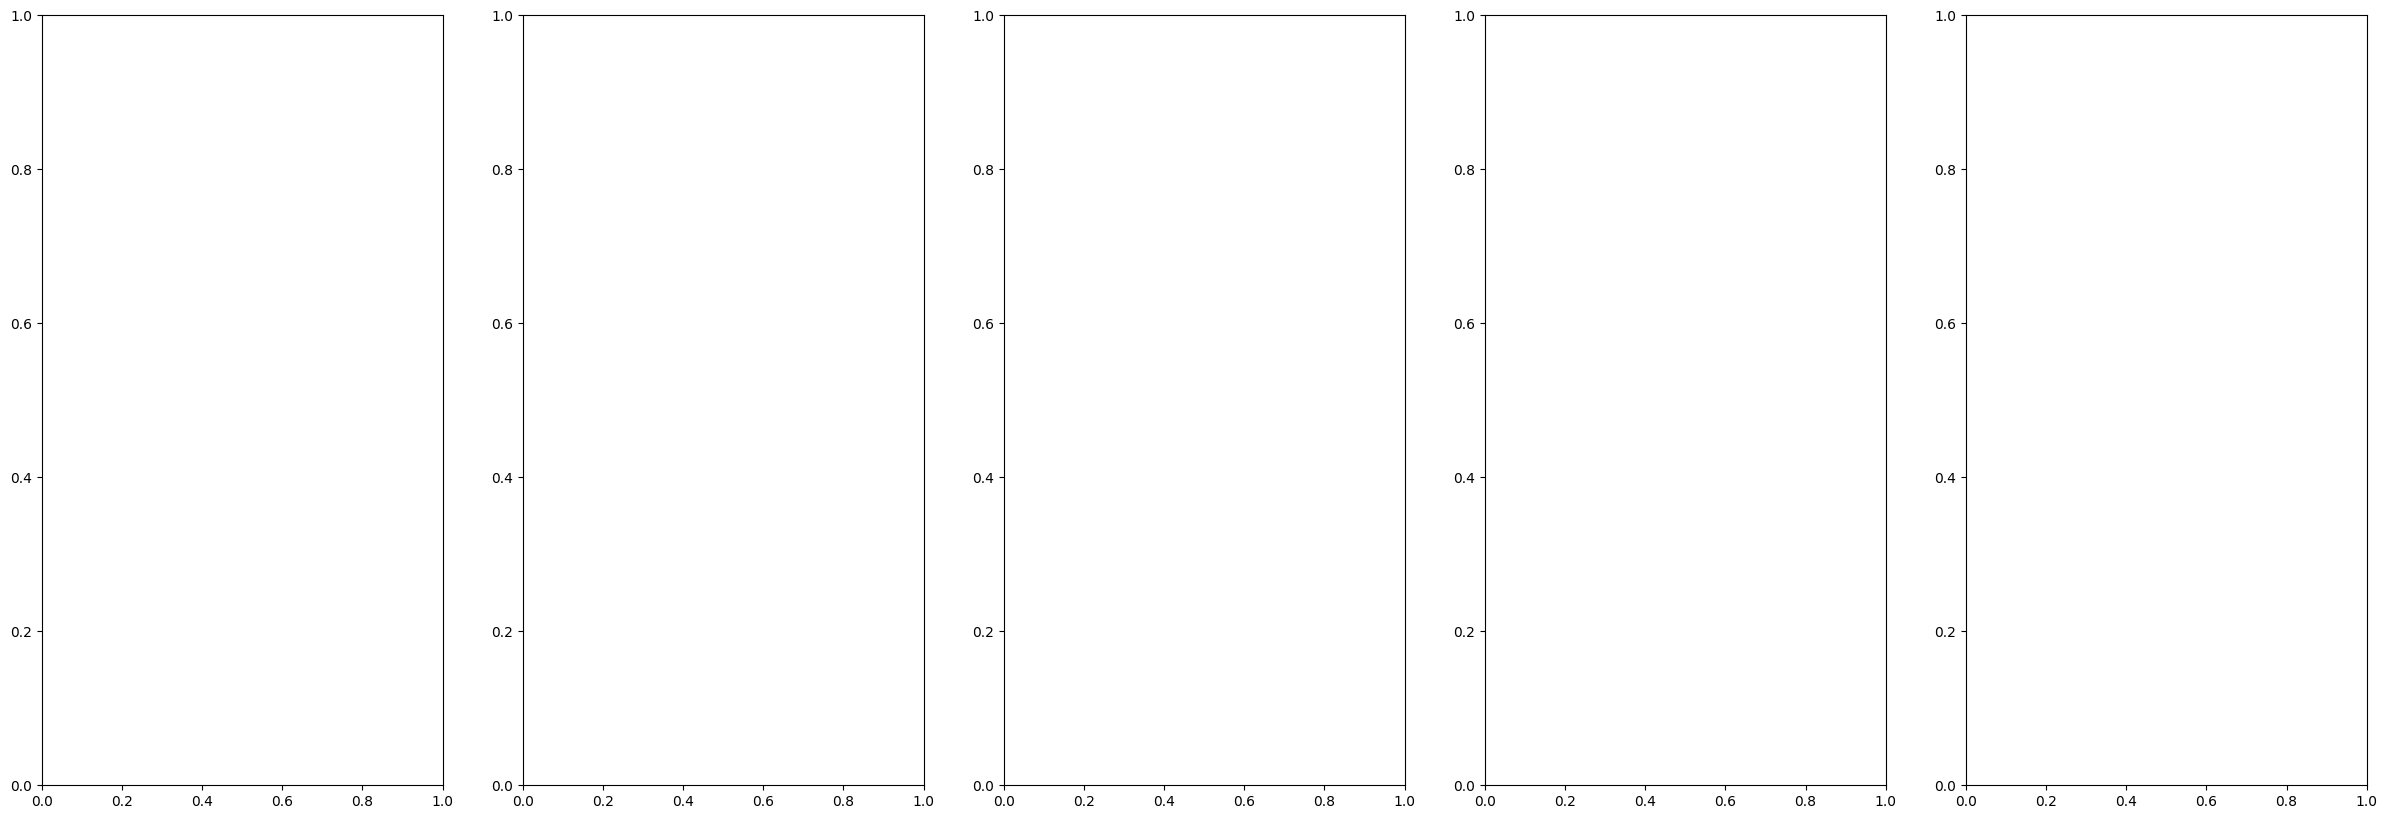

In [32]:
condition_name = cond1 + '_' + cond2

# Initialize Figure
fig, axes = plt.subplots(1, 5, figsize=(30, 10))

topomap_kw = dict(ch_type='mag', tmin=0.5, tmax=1.5, baseline=(-0.5, 0),
                mode='logratio', show=False)

fig_path = FIG_PATH + 'clusters-psd/sub-all_run-all_task-{}_cond-LaughReal_LaughPosed'.format(task)
 

for i, ax in enumerate(axes):
    
    freq = freq_name[i]
        
    cluster_stats = all_freqs_clusters[freq]
    F_obs, clusters, p_values, _ = cluster_stats

    p_accept = 0.01
    good_cluster_inds = np.where(p_values < p_accept)[0]

    if len(good_cluster_inds) > 0:

        for i_clu, clu_idx in enumerate(good_cluster_inds):
            # unpack cluster information, get unique indices
            time_inds, space_inds = np.squeeze(clusters[clu_idx])
            ch_inds = np.unique(space_inds)
            time_inds = np.unique(time_inds)

            t_map = F_obs[time_inds, ...].mean(axis=0)

            # create spatial mask
            mask = np.zeros((t_map.shape[0], 1), dtype=bool)
            mask[ch_inds, :] = True

            # plot average test statistic and mark significant sensors
            f_evoked = mne.EvokedArray(t_map[:, np.newaxis], epochs.info, tmin=0)
            f_evoked.plot_topomap(times=0, mask=mask, axes=ax, cmap='bwr',
                                  show=False,
                                  cnorm = matplotlib.colors.CenteredNorm(vcenter=0),
                                  colorbar=False, mask_params=dict(markersize=10), 
                                  extrapolate='head',
                                  sphere=(0, 0.017, 0, 0.184))

            image = ax.images[0]

            # remove the title that would otherwise say "0.000 s"
            title = FREQS_NAMES[i] + ' ' + str(FREQS_LIST[i])
            ax.set_title(title, size = 25)

    else : 
        t_map = np.squeeze(F_obs)
        # time_inds, space_inds = np.squeeze(clusters[clu_idx])
        # ch_inds = np.unique(space_inds)
        # time_inds = np.unique(time_inds)
        # t_map = F_obs[time_inds, ...].mean(axis=0)


        # plot average test statistic without mark significant sensors
        f_evoked = mne.EvokedArray(t_map[:, np.newaxis], epochs.info, tmin=0)
        f_evoked.plot_topomap(times=0, axes=ax, cmap='bwr',
                              vlim=(np.min, np.max), show=False,
                              colorbar=False, extrapolate='head',
                                  sphere=(0, 0.017, 0, 0.184))

        image = ax.images[0]

        # remove the title that would otherwise say "0.000 s"
        title = FREQS_NAMES[i] + ' ' + str(FREQS_LIST[i])
        ax.set_title(title, size = 25)


# create additional axes (for ERF and colorbar)
divider = make_axes_locatable(ax)

# add axes for colorbar
ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(image, cax=ax_colorbar)

figure_title = 'Topographic map of T-values \n Comparison between real and posed laughter for the active task'
plt.suptitle(figure_title, size = 30)
fig.tight_layout()
fig.savefig(fig_path)

----------------------------------------------------------------------------------------------------------------

# TEST TIME FREQUENCY

In [2]:
task = 'LaughterActive'
cond1 = 'LaughReal'
cond2 = 'LaughPosed'
condition = cond1 + '-' + cond2
stage = 'morlet-tfr'

event_id = [11, 12]

In [51]:
all_evoked = [] 
all_evoked_cond1 = []
all_evoked_cond2 = []
contrasts_all_subject = []
power_all_subject = []

for subj in SUBJ_CLEAN:
    print("=> Process task :", task, 'subject', subj)

    _, epo_path = get_bids_file(RESULT_PATH, stage='AR_epo', task=task, subj=subj)
    epochs = mne.read_epochs(epo_path)
    epochs.pick_types(meg=True, ref_meg = False,  exclude='bads')

    # Average for one condition
    all_evoked_cond1.append(epochs[cond1].average())
    all_evoked_cond2.append(epochs[cond2].average())
    
    # Constrast cond1 - cond2
    contrast = mne.combine_evoked([epochs[cond1].average(), epochs[cond2].average()], weights=[1, -1])
    contrast.pick_types(meg=True, ref_meg=False,  exclude='bads')
    
    # Apply power
    power_contrast = tfr_morlet(contrast, freqs=freqs, n_cycles=n_cycles, use_fft=False,
                        return_itc=False, decim=3, n_jobs=None, average=False)
    power_contrast.apply_baseline(mode="ratio", baseline=(None, 0))

    power_all_subject.append(power_contrast)
    contrasts_all_subject.append(contrast)
    
# Combine all subjects
evokeds_cond1 = mne.combine_evoked(all_evoked_cond1, weights='equal')
evokeds_cond2 = mne.combine_evoked(all_evoked_cond2, weights='equal')

# Combine all subject together
evoked_contrast = mne.combine_evoked(contrasts_all_subject, 'equal')
    
# Compute freqs from 2 - 60 Hz
freqs = np.logspace(*np.log10([2, 60]))
n_cycles = freqs / 2.  # different number of cycle per frequency
power_cond1 = tfr_morlet(evokeds_cond1, freqs=freqs, n_cycles=n_cycles, use_fft=False,
                        return_itc=False, decim=3, n_jobs=None, average=False)

power_cond2 = tfr_morlet(evokeds_cond2, freqs=freqs, n_cycles=n_cycles, use_fft=False,
                        return_itc=False, decim=3, n_jobs=None, average=False)

power_cond1.apply_baseline(mode="ratio", baseline=(None, 0))
power_cond2.apply_baseline(mode="ratio", baseline=(None, 0))

=> Process task : LaughterActive subject 01
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
296 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-02/sub-02_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.2s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
295 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-03/sub-03_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.8s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
298 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-04/sub-04_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.8s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
292 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.2s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
281 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 06
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-06/sub-06_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.9s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
299 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 07
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-07/sub-07_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.8s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
300 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 08
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-08/sub-08_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.6s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
297 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 09
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-09/sub-09_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.4s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
294 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 10
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.6s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
299 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 11
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-11/sub-11_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.9s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
278 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 12
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-12/sub-12_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.4s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
292 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 13
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-13/sub-13_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.7s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
289 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 14
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.6s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
292 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 15
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-15/sub-15_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.6s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
295 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 16
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-16/sub-16_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.5s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
297 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 18
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-18/sub-18_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.4s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
294 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 19
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-19/sub-19_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.7s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
298 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 20
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.2s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
300 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 21
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-21/sub-21_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.6s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
300 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 22
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-22/sub-22_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.7s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
298 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 23
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-23/sub-23_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.5s finished


Adding metadata with 7 columns
185 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 24
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.6s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
297 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 25
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-25/sub-25_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.1s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
300 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 28
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-28/sub-28_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.6s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
289 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 30
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-30/sub-30_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.6s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
300 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
=> Process task : LaughterActive subject 32
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-32/sub-32_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.2s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
299 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.4s finished


<EpochsTFR | time : [-0.500000, 1.500000], freq : [2.000000, 60.000000], epochs : 1, channels : 270, ~83.6 MB>

In [52]:
X = np.array([c.data for c in power_all_subject])
X = np.mean(X, axis=1)
print(X.shape)
X = np.transpose(X, [0, 3, 2, 1])
print(X.shape)

(27, 270, 50, 801)
(27, 801, 50, 270)


In [53]:
print('Computing adjacency.')
adjacency, ch_names = compute_ch_adjacency(evoked_contrast.info, ch_type='mag')
print(adjacency.shape)

Computing adjacency.
-- number of adjacent vertices : 270
(270, 270)


In [19]:
# epochs_power_1 = power_cond1.data[:, 10, :, :]  # only 1 channel as 3D matrix
# epochs_power_2 = power_cond2.data[:, 10, :, :]  # only 1 channel as 3D matrix

epochs_power_1 = np.mean(power_cond1.data, axis=0)
epochs_power_2 = np.mean(power_cond2.data, axis=0)
print(epochs_power_2.shape)

(270, 50, 801)


In [23]:
contrast = np.subtract(epochs_power_1, epochs_power_2)
print(contrast.shape)

contrast = np.transpose(contrast, [2, 1, 0])
print(contrast.shape)

(270, 50, 801)
(801, 50, 270)


In [54]:
degrees_of_freedom = 25 - 1
t_thresh = scipy.stats.t.ppf(1 - 0.001 / 2, df=degrees_of_freedom)

# Run the analysis
print('Clustering.')
cluster_stats = \
    spatio_temporal_cluster_1samp_test(X, n_permutations=1024,
                                threshold=t_thresh, tail=0,
                                adjacency=adjacency,
                                out_type='indices', verbose=None, 
                                step_down_p = 0.05, check_disjoint=True)

good_cluster_inds = np.where(cluster_p_values < 0.01)[0]
print("Good clusters: %s" % good_cluster_inds)

Clustering.


ValueError: adjacency (len 270) must be of the correct size, i.e. be equal to or evenly divide the number of tests (10813500).

If adjacency was computed for a source space, try using the fwd["src"] or inv["src"] as some original source space vertices can be excluded during forward computation

NameError: name 'ch_name' is not defined

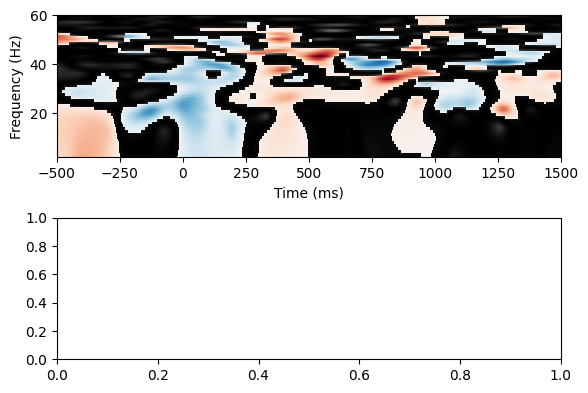

In [15]:
times = 1e3 * epochs.times  # change unit to ms

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4))
fig.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

# Compute the difference in evoked to determine which was greater since
# we used a 1-way ANOVA which tested for a difference in population means
evoked_power_1 = epochs_power_1.mean(axis=0)
evoked_power_2 = epochs_power_2.mean(axis=0)
evoked_power_contrast = evoked_power_1 - evoked_power_2
signs = np.sign(evoked_power_contrast)

# Create new stats image with only significant clusters
F_obs_plot = np.nan * np.ones_like(F_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        F_obs_plot[c] = F_obs[c] * signs[c]

ax.imshow(
    F_obs,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="gray",
)
max_F = np.nanmax(abs(F_obs_plot))
ax.imshow(
    F_obs_plot,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
    vmin=-max_F,
    vmax=max_F,
)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title(f"Induced power ({ch_name})")

# plot evoked
#evoked_condition_1 = epochs_condition_1.average()
#evoked_condition_2 = epochs_condition_2.average()
evoked_contrast = mne.combine_evoked(
    [evokeds_cond1, evokeds_cond2], weights=[1, -1]
)
evoked_contrast.plot(axes=ax2, time_unit="s")

## Plot Time-Freq per conditions
With Morlet

In [2]:
task = 'LaughterActive'
cond1 = 'Good'
cond2 = 'LaughPosed'
condition = cond1 + '-' + cond2
stage = 'morlet-tfr'
vmin, vmax = -3.0, 3.0  # Define our color limits.


In [3]:
all_evoked = []

for subj in SUBJ_CLEAN:
    print("=> Process task :", task, 'subject', subj)

    _, epo_path = get_bids_file(RESULT_PATH, stage='AR_epo', task=task, subj=subj)
    epochs = mne.read_epochs(epo_path)
    epochs.pick_types(meg=True, ref_meg = False,  exclude='bads')

    # Average for one condition
    all_evoked.append(epochs[cond1].average())

# Combine all subjects
evokeds = mne.combine_evoked(all_evoked, weights='equal')

=> Process task : LaughterActive subject 01
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterActive_run-all_AR_epo.fif ...


KeyboardInterrupt: 

In [4]:
# Compute freqs from 2 - 60 Hz
freqs = np.logspace(*np.log10([2, 60]))
n_cycles = freqs / 2.  # different number of cycle per frequency

all_tfr_power = []

for subj in SUBJ_CLEAN : 
    _, epo_path = get_bids_file(RESULT_PATH, stage='AR_epo', task=task, subj=subj)
    epochs = mne.read_epochs(epo_path)
    epochs.pick_types(meg=True, ref_meg = False,  exclude='bads')
    
    power = tfr_morlet(epochs[cond1], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=False, decim=3, n_jobs=None, average=True)
    
    all_tfr_power.append(power)
    
print(len(all_tfr_power))

Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
296 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.5min finished


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-02/sub-02_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
295 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.5min finished


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-03/sub-03_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
298 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-04/sub-04_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.8min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
292 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.8min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
281 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-06/sub-06_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.7min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
299 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-07/sub-07_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.3min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
300 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-08/sub-08_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.2min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
297 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.7min finished


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-09/sub-09_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
294 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.7min finished


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
299 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-11/sub-11_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.8min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
278 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.4min finished


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-12/sub-12_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
292 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-13/sub-13_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  2.2min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
289 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  2.0min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
292 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-15/sub-15_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.9min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
295 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-16/sub-16_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.7min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
297 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-18/sub-18_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  2.1min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
294 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-19/sub-19_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.8min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
298 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.2s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.9min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
300 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-21/sub-21_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.8min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
300 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-22/sub-22_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.8min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
298 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-23/sub-23_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.7min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
185 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   39.7s finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
297 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-25/sub-25_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.4min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
300 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-28/sub-28_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.8min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
289 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-30/sub-30_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.6min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
300 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s


Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-32/sub-32_task-LaughterActive_run-all_AR_epo.fif ...


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  2.0min finished


    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
299 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


27


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.7min finished


In [5]:
grand_average_tfr = mne.grand_average(all_tfr_power)

Identifying common channels ...


Applying baseline correction (mode: mean)


[<Figure size 640x480 with 2 Axes>]

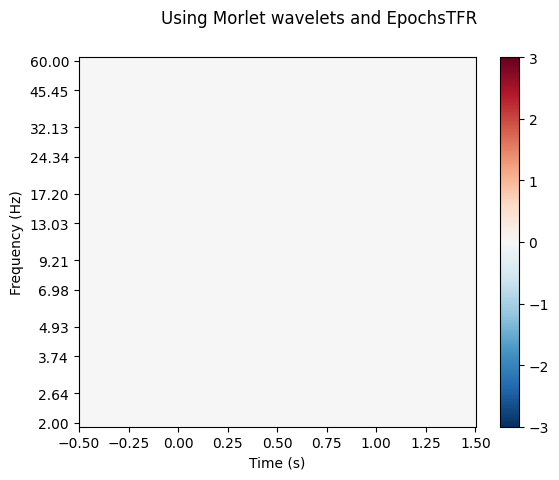

In [5]:
#avgpower = power.average()

grand_average_tfr.plot(
    [0],
    baseline=(0.0, 0.1), 
    mode="mean",
    vmin=vmin,
    vmax=vmax,
    title="Using Morlet wavelets and EpochsTFR",
    show=False,
)

No baseline correction applied


/tmp/ipykernel_284534/1709433363.py:3: RuntimeWarning: Provided cnorm implicitly defines vmin=None and vmax=None; ignoring additional vlim/vmin/vmax params.
  fig = grand_average_tfr.plot_topomap(axes=ax, cmap='bwr', extrapolate='head',


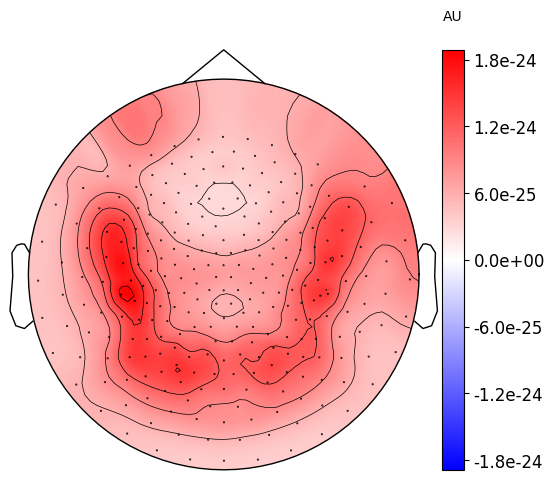

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

fig = grand_average_tfr.plot_topomap(axes=ax, cmap='bwr', extrapolate='head',
                            sphere=(0, 0.02, 0, 0.19), 
                            cnorm = matplotlib.colors.CenteredNorm(vcenter=0))

plt.show()

No baseline correction applied


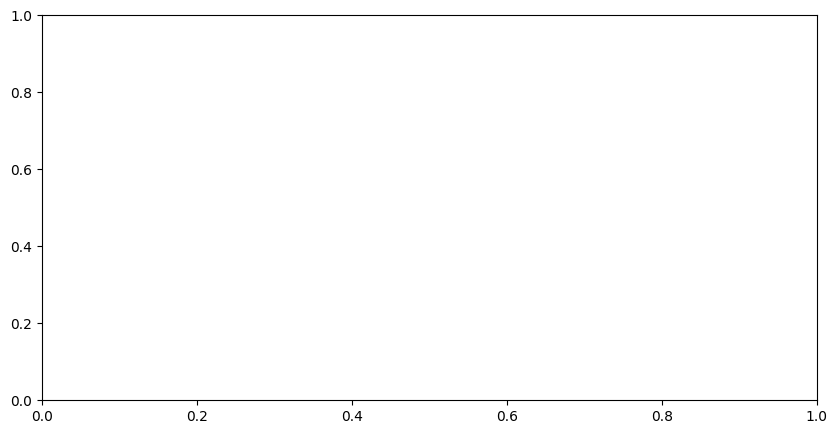

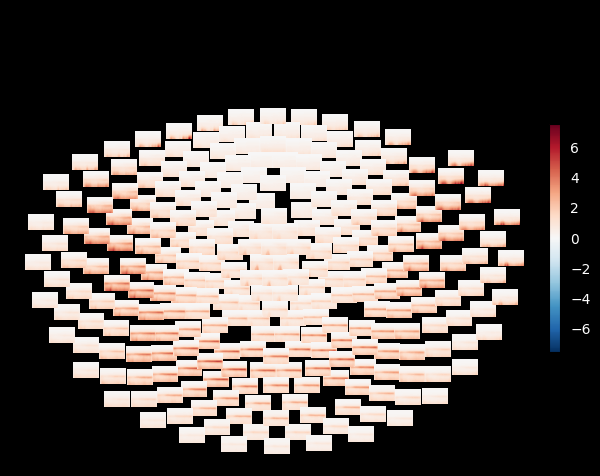

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

fig = grand_average_tfr.pick_types(meg="mag").plot_topo()

plt.show()